<a href="https://colab.research.google.com/github/okada-t-rafael/pytorch_study/blob/master/02_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Neural Network classification with Pytorch

Classification is a problem of prediction whether something is one thing or another (there can be multiple things as the options).

* Book version: https://www.learnpytorch.io/02_pytorch_classification/

* All other resources: https://github.com/mrdbourke/pytorch-deep-learning

## 1. Make classification data and get it ready

In [1]:
!pip install torchmetrics

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import torch

from sklearn.datasets import make_blobs, make_circles
from sklearn.model_selection import train_test_split
from torch import nn
from torchmetrics import Accuracy

torch.__version__

'2.0.1+cu118'

In [3]:
# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [4]:
print(f"First 5 samples of X:\n{X[:5]}")
print(f"\nFirst 5 samples of y:\n{y[:5]}")

First 5 samples of X:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 samples of y:
[1 1 1 1 0]


In [5]:
circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


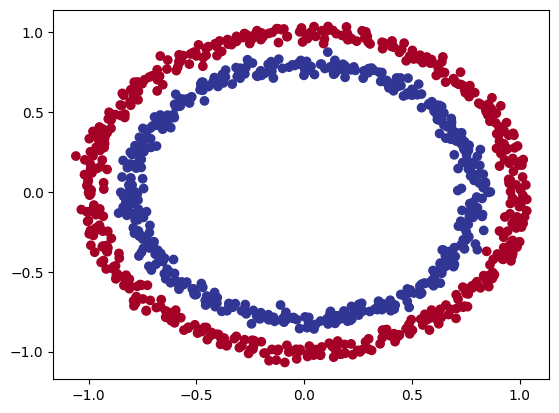

In [6]:
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu);

**Note**: The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment on but still sizeable enough to practice the fundamentals.

### 1.1 Check input and output shapes

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [9]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float).unsqueeze(dim=1)

In [10]:
X[:5], X.dtype

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 torch.float32)

In [11]:
y[:5], y.dtype

(tensor([[1.],
         [1.],
         [1.],
         [1.],
         [0.]]),
 torch.float32)

In [12]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [13]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [14]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [15]:
# Put data on the target device
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

Now that we've setup device agnostic code, let's create a model that:

1. Subclasses `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that outlines the forward pass (or forward computation of the model
4. Instantiate an instance of our model class and send it to the target `device`

In [16]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()

        # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=5)  # takes in 2 features and upscales to 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1)  # takes in 5 features from previous layer and outputs a single feature (same shape as y)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer_2(self.layer_1(x))  # x -> layer_1 -> layer_2 -> output

In [17]:
# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
# Let's replicate the model above using nn.Sequential()
model_temp = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_temp

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.1657, -0.6545],
                      [ 0.3772, -0.5008],
                      [-0.4256,  0.3228],
                      [ 0.6186,  0.4743],
                      [ 0.3142,  0.5098]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.0873,  0.6925, -0.6516, -0.6439, -0.1391], device='cuda:0')),
             ('layer_2.weight',
              tensor([[-0.2650, -0.0650,  0.4110, -0.2520, -0.2584]], device='cuda:0')),
             ('layer_2.bias', tensor([0.1630], device='cuda:0'))])

In [20]:
# Make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test)
    print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
    print(f"Lenght of test samples: {len(y_test)}, Shape: {y_test.shape}")
    print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
    print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Lenght of test samples: 200, Shape: torch.Size([200, 1])

First 10 predictions:
tensor([[ 0.2785],
        [ 0.1494],
        [ 0.3200],
        [ 0.2680],
        [-0.1514],
        [-0.2266],
        [-0.2165],
        [-0.3058],
        [ 0.3398],
        [ 0.1355]], device='cuda:0')

First 10 labels:
tensor([[1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.]], device='cuda:0')


### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?

Again... this is problem specific.

For example for regression you might want MAE or MSE (mean absolute error or mean squared error).

For classification you might want binary cross entropy or categorical cross entropy (cross entropy).

As a reminder, the loss function measures how *wrong* your models predictions are.

And for optimizers, two of the most common and useful are SGC and Adam, however PyTorch has many built-in options.

* For some common choices of loss functions and optimizers: https://www.learnpytorch.io/02_pytorch_classification/#21-setup-loss-function-and-optimizer
* For the loss function we're goind to use `torch.nn.BECWithLogitsLoss()`, for more on what binary cross entropy (BCE) is, check out this article: https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a
* For a definition on waht a logit is in deep learning: https://stackoverflow.com/a/52111173/7900723
* For different optimizers see `torch.optim`

In [21]:
# Setup the loss function & optimizer
# loss_fn = nn.BCELoss()  # BCELoss = requires inputs to have gone through the sigmoid activation function prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss()  # BCEWithLogitsLoss = sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [22]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return (correct / len(y_pred)) * 100

## 3. Train model

To train our model, we're going to need to build a training loop with the following steps:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropragation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model output are going to be raw **logits**.

We can convert these **logits** into prediction probabilities by passing them to some king of activation function (e.g. sigmoid for binary crossentropy and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to **prediction labels** by either rouding them or taking the `argmax()`.

In [23]:
# View the first 5 outputs of the forward pass on the test data
with torch.inference_mode():
    y_logits = model_0(X_test)[:5]
y_logits

tensor([[ 0.2785],
        [ 0.1494],
        [ 0.3200],
        [ 0.2680],
        [-0.1514]], device='cuda:0')

In [24]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_prob = torch.sigmoid(y_logits)
y_pred_prob

tensor([[0.5692],
        [0.5373],
        [0.5793],
        [0.5666],
        [0.4622]], device='cuda:0')

For our prediction probability values, we need to perform a range-style rouding on them:
* `y_pred_prob` >= 0.5, `y=1` (class 1)
* `y_pred_prob` < 0.5, `y=0` (class 0)

In [25]:
# Find the predicted labels
y_pred = torch.round(y_pred_prob)

# Check for equality
print(torch.eq(y_pred, y_test[:5]))

tensor([[ True],
        [False],
        [ True],
        [False],
        [False]], device='cuda:0')


### 3.2 Bulding a training and testing loop

In [26]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Build training and evaluation loop
for epoch in range(epochs):
    # Training
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_train)
    y_pred_prob = torch.sigmoid(y_logits)
    y_pred  = torch.round(y_pred_prob)

    # 2. Calculate loss/acc
    # loss = loss_fn(y_pred_prob, y_train)  # nn.BCELoss expects prediction probabilities as input
    loss = loss_fn(y_logits, y_train)  # nn.BCEWithLogitsLoss expects raw logits as input
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()

    # Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test)
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate test loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print out what's happenin'
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70256, Acc: 50.12% | Test loss: 0.69921, Test acc: 51.50%
Epoch: 10 | Loss: 0.70042, Acc: 50.25% | Test loss: 0.69810, Test acc: 50.50%
Epoch: 20 | Loss: 0.69895, Acc: 50.00% | Test loss: 0.69738, Test acc: 50.50%
Epoch: 30 | Loss: 0.69786, Acc: 50.00% | Test loss: 0.69686, Test acc: 51.50%
Epoch: 40 | Loss: 0.69701, Acc: 50.00% | Test loss: 0.69647, Test acc: 52.50%
Epoch: 50 | Loss: 0.69633, Acc: 49.50% | Test loss: 0.69618, Test acc: 54.50%
Epoch: 60 | Loss: 0.69579, Acc: 49.50% | Test loss: 0.69595, Test acc: 55.50%
Epoch: 70 | Loss: 0.69535, Acc: 49.12% | Test loss: 0.69577, Test acc: 53.00%
Epoch: 80 | Loss: 0.69499, Acc: 50.25% | Test loss: 0.69563, Test acc: 53.50%
Epoch: 90 | Loss: 0.69469, Acc: 49.75% | Test loss: 0.69551, Test acc: 53.50%


## 4. Make predicitons  and evaluate the model

From the metrics it looks like our model isn't learning anything... So to inspect it le'ts make some predictions and make them visual! In other words, "Visualize, visualize, visualize!"

To do so, we're going to import a function called `plot_decision_boundary()`: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [27]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Download helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")

    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


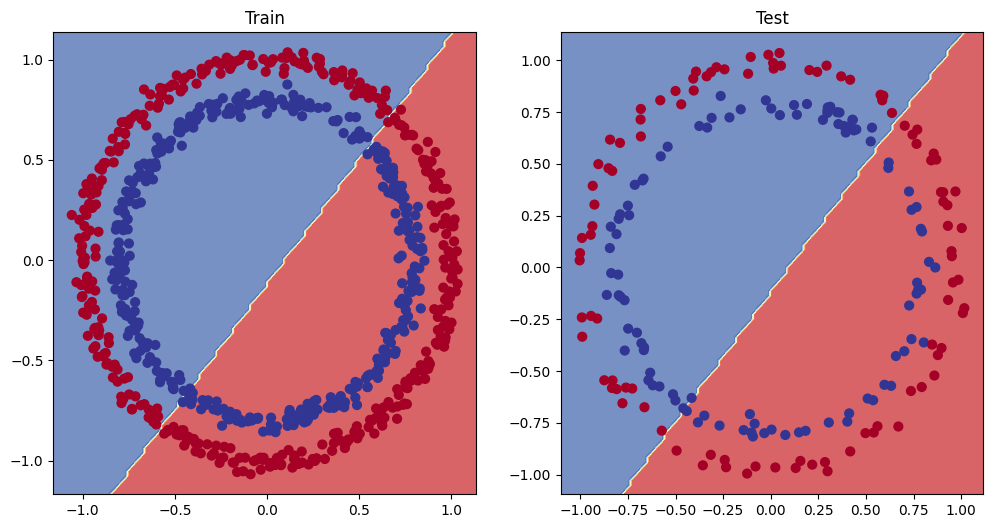

In [28]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data.
* Add more hidden units/parameters - e.g. go from 5 hidden units to 10.
* Fit for longer.
* Chaning the activation functions.
* Change the learning rate.
* Change the loss function.

These options are all from a model's perspective because they deal directly with the model, rather than the data.

And because these options are all values we (as machine learning engineers and data scientists) can change, they are referred as **hyperparameters**.

Let's try and improve our model by:
* Adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 100 -> 1000


In [29]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer_3(self.layer_2(self.layer_1(x)))

In [30]:
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [31]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [32]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Build training and evaluation loop
for epoch in range(epochs):
    # Training
    model_1.train()

    # 1. Forward pass
    y_logits = model_1(X_train)
    y_pred_prob = torch.sigmoid(y_logits)
    y_pred  = torch.round(y_pred_prob)

    # 2. Calculate loss/acc
    # loss = loss_fn(y_pred_prob, y_train)  # nn.BCELoss expects prediction probabilities as input
    loss = loss_fn(y_logits, y_train)  # nn.BCEWithLogitsLoss expects raw logits as input
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()

    # Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test)
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate test loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print out what's happenin'
    if epoch % 50 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 50 | Loss: 0.69322, Acc: 49.88% | Test loss: 0.69324, Test acc: 50.00%
Epoch: 100 | Loss: 0.69305, Acc: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 150 | Loss: 0.69300, Acc: 51.00% | Test loss: 0.69415, Test acc: 47.00%
Epoch: 200 | Loss: 0.69299, Acc: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 250 | Loss: 0.69298, Acc: 51.62% | Test loss: 0.69450, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Acc: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 350 | Loss: 0.69298, Acc: 51.12% | Test loss: 0.69462, Test acc: 45.50%
Epoch: 400 | Loss: 0.69298, Acc: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 450 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69466, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 550 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.

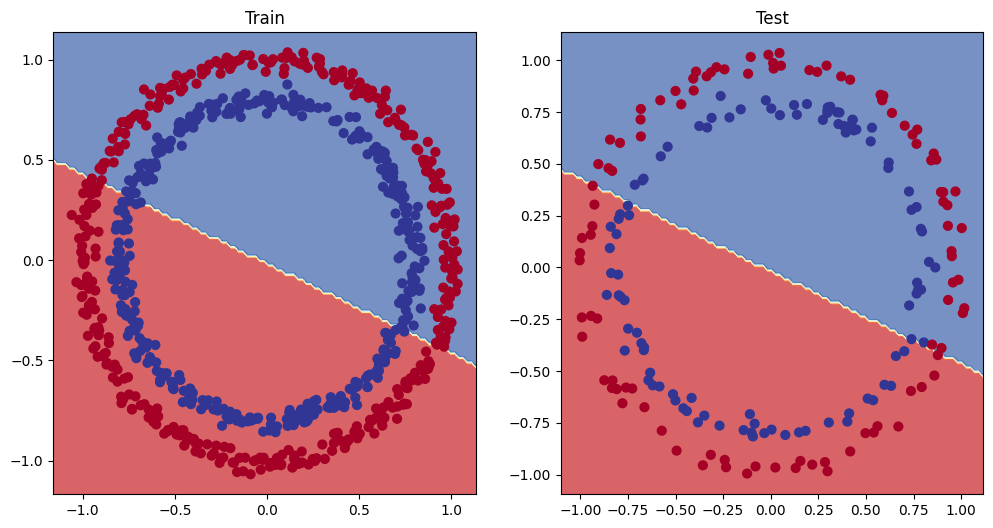

In [33]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot to a larger problem is to test out a smaller problem.

In [34]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias + (torch.randn(size=(100, 1)) * 0.05)

# Check the data
X_regression[:5], y_regression[:5]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3963],
         [0.3814],
         [0.3590],
         [0.2157],
         [0.3619]]))

In [35]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

In [36]:
# Check the lengths of each
print(len(X_train_regression), len(X_test_regression))
print(len(y_train_regression), len(y_test_regression))

80 20
80 20


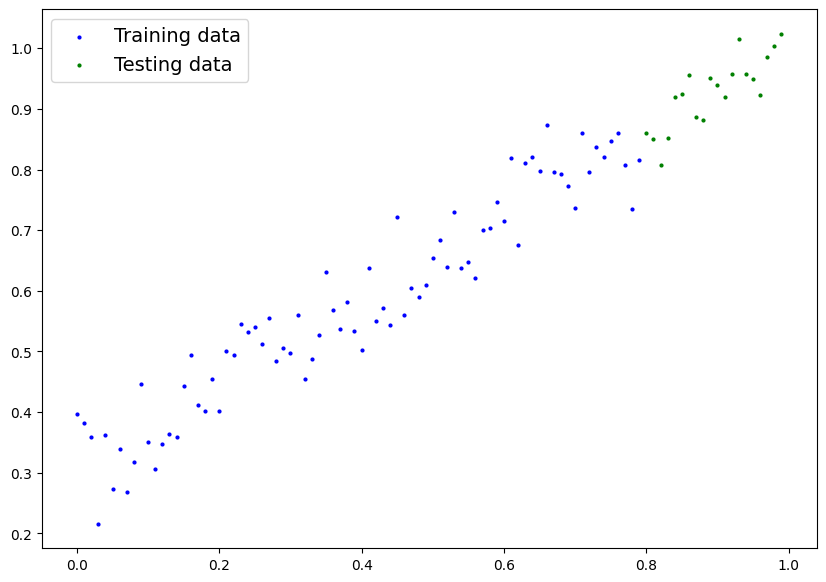

In [37]:
plot_predictions(
    train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression)

In [38]:
X_train_regression = X_train_regression.to(device)
y_train_regression = y_train_regression.to(device)
X_test_regression = X_test_regression.to(device)
y_test_regression = y_test_regression.to(device)

### 5.2 Adjusting `model_1` to fit a straight line

In [39]:
# Same architecture as model_1 (but using nn.Sequential())
model_temp_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)).to(device)

In [40]:
model_temp_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [41]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_temp_2.parameters(), lr=0.1)

In [42]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

for epoch in range(epochs):
    # Training
    model_temp_2.train()
    y_pred = model_temp_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    model_temp_2.eval()
    with torch.inference_mode():
        test_pred = model_temp_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happin'
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.34930 | Test loss: 0.27075
Epoch: 100 | Loss: 0.10534 | Test loss: 0.03027
Epoch: 200 | Loss: 0.07763 | Test loss: 0.04818
Epoch: 300 | Loss: 0.05590 | Test loss: 0.04052
Epoch: 400 | Loss: 0.05380 | Test loss: 0.03306
Epoch: 500 | Loss: 0.04399 | Test loss: 0.02710
Epoch: 600 | Loss: 0.04401 | Test loss: 0.02658
Epoch: 700 | Loss: 0.04401 | Test loss: 0.02657
Epoch: 800 | Loss: 0.04399 | Test loss: 0.02692
Epoch: 900 | Loss: 0.04434 | Test loss: 0.02680


In [43]:
# Turn on evaulation
model_temp_2.eval()

# Make predictions
with torch.inference_mode():
    y_pred = model_temp_2(X_test_regression)

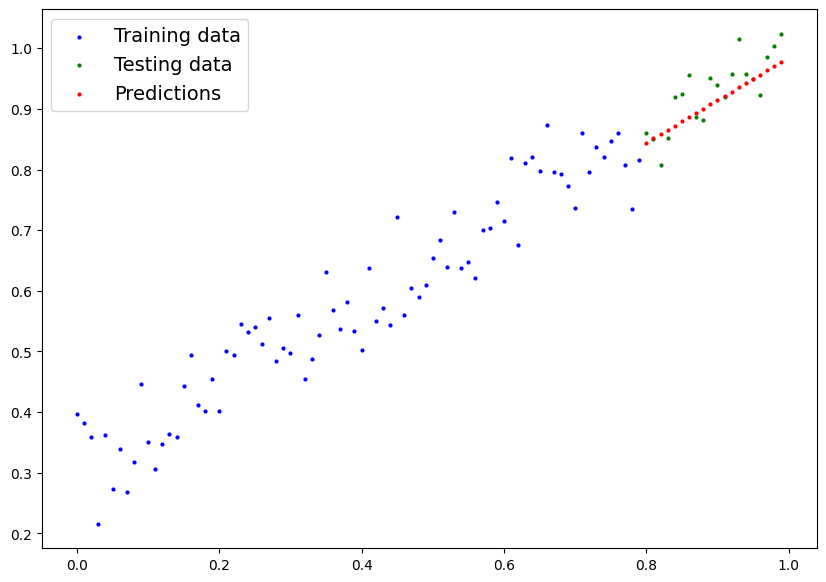

In [44]:
# Plot data and predictions
plot_predictions(
    train_data=X_train_regression.cpu(),
    train_labels=y_train_regression.cpu(),
    test_data=X_test_regression.cpu(),
    test_labels=y_test_regression.cpu(),
    predictions=y_pred.cpu())

## 6. The missing piece: non-linearity

"What patterns could you draw if you were given an infinite amount of a straight and non-straight lines?"

Or in machine learning terms, an infinite (but really it is finite) of linear an non-linear functions?

### 6.1 Building a model with non-linearity

* Linear = straight lines
* Non-linear = non-straight lines

Artificial neural network are a large combination of linear (straight) and non-straight (non-linear) functions which are potentially able to find patterns in data.

In [45]:
# Build a model with non-linear activation functions
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()  # relu is a non-linear activation function

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Where should we put our non-linear activation functions?
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [46]:
model_2 = CircleModelV2().to(device)
model_2

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [47]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [48]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the epochs
epochs = 1000

for epoch in range(epochs):
    # Training
    model_2.train()

    # 1. Forward pass
    y_logits = model_2(X_train)
    y_pred_prob = torch.sigmoid(y_logits)
    y_pred  = torch.round(y_pred_prob)

    # 2. Calculate loss/acc
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()

    # Testing
    model_2.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_2(X_test)
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate test loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print out what's happenin'
    if epoch % 50 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Acc: 50.00% | Test loss: 0.69319, Test acc: 50.00%
Epoch: 50 | Loss: 0.69181, Acc: 58.25% | Test loss: 0.69177, Test acc: 58.00%
Epoch: 100 | Loss: 0.69115, Acc: 52.88% | Test loss: 0.69102, Test acc: 52.50%
Epoch: 150 | Loss: 0.69050, Acc: 52.88% | Test loss: 0.69027, Test acc: 55.00%
Epoch: 200 | Loss: 0.68977, Acc: 53.37% | Test loss: 0.68940, Test acc: 55.00%
Epoch: 250 | Loss: 0.68894, Acc: 53.50% | Test loss: 0.68840, Test acc: 56.00%
Epoch: 300 | Loss: 0.68795, Acc: 53.00% | Test loss: 0.68723, Test acc: 56.00%
Epoch: 350 | Loss: 0.68676, Acc: 52.62% | Test loss: 0.68587, Test acc: 56.50%
Epoch: 400 | Loss: 0.68517, Acc: 52.75% | Test loss: 0.68411, Test acc: 56.50%
Epoch: 450 | Loss: 0.68326, Acc: 52.75% | Test loss: 0.68198, Test acc: 56.00%
Epoch: 500 | Loss: 0.68102, Acc: 52.75% | Test loss: 0.67941, Test acc: 56.50%
Epoch: 550 | Loss: 0.67837, Acc: 53.37% | Test loss: 0.67641, Test acc: 56.00%
Epoch: 600 | Loss: 0.67515, Acc: 54.50% | Test loss: 0.

### 6.4 Evaluating a model trained with non-linear activation functions

In [49]:
# Make predictions
model_2.eval()
with torch.inference_mode():
    y_logits = model_2(X_test)
    y_pred = torch.round(torch.sigmoid(y_logits))
y_pred[:10].squeeze(), y_test[:10].squeeze()

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

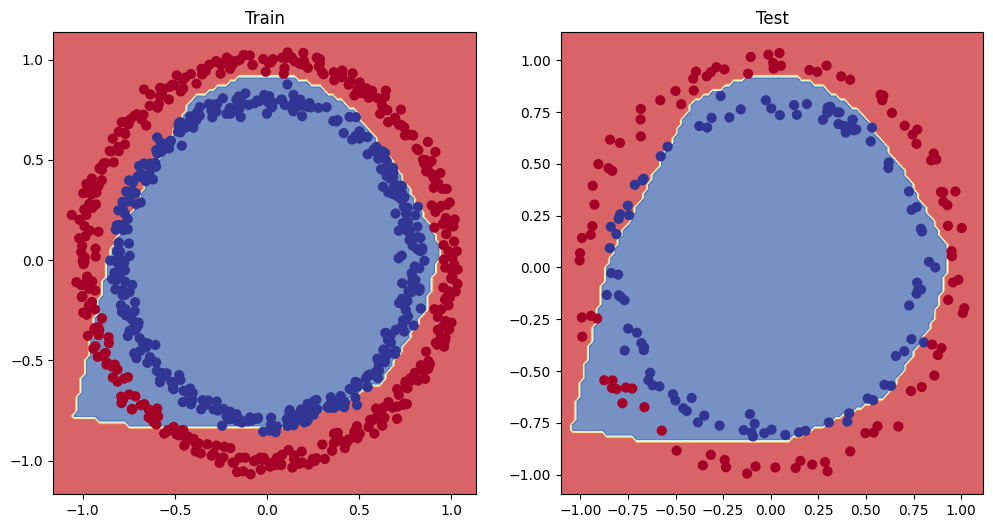

In [50]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)

## 7. Replicating non-linear activation functions

Neural networks, rather than us telling what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own.

And these tools are linea & non-linear functions.

In [51]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

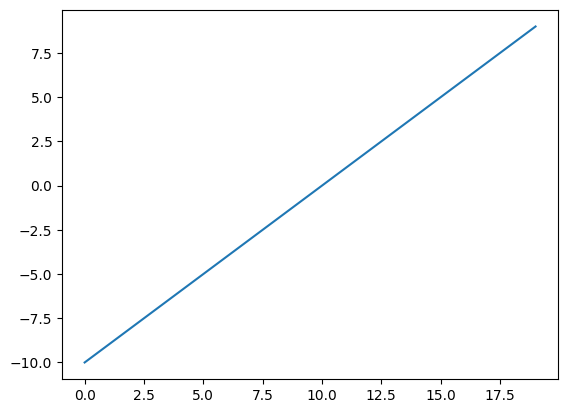

In [52]:
# Visualize the tensor
plt.plot(A);

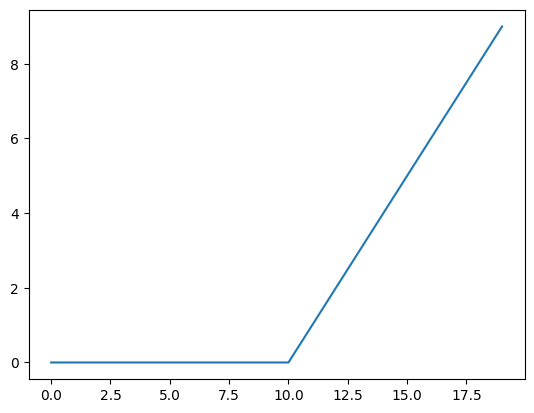

In [53]:
plt.plot(torch.relu(A));

In [54]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x)

In [55]:
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

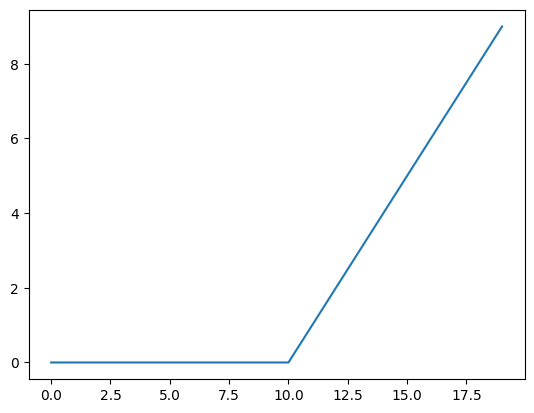

In [56]:
plt.plot(relu(A));

In [57]:
def sigmoid(x: torch.tensor) -> torch.Tensor:
    return 1 / (1 + torch.exp(-x))

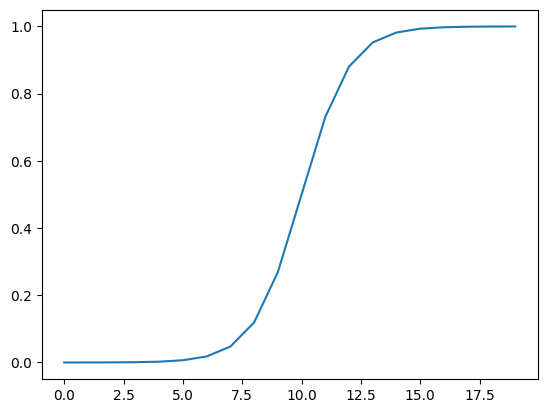

In [58]:
plt.plot(torch.sigmoid(A));

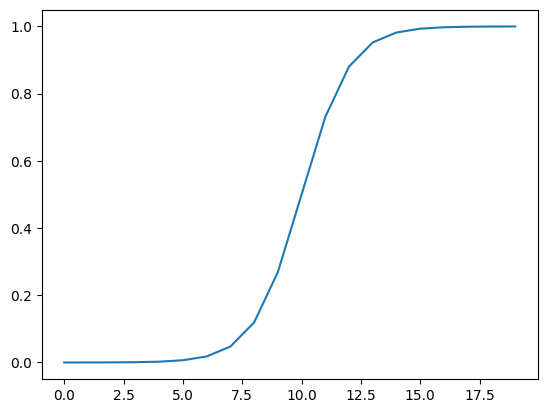

In [59]:
plt.plot(sigmoid(A));

## 8. Putting it all together with a multi-class classification problem

* Binary classification = one thing or another (cat vs. dog, spam vs. not spam, fraud or not fraud)
* Multi-class classification = more than one thing or another (cat vs. dog vs. chicken)

### 8.1 Creating a toy multi-class dataset

In [60]:
# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

In [61]:
# Create multi-class data
X_blob, y_blob = make_blobs(
    n_samples=1000,
    n_features=NUM_FEATURES,
    centers=NUM_CLASSES,
    cluster_std=1.75,
    random_state=RANDOM_SEED)

In [62]:
# Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

In [63]:
X_blob.shape, y_blob.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [64]:
X_blob[:5], y_blob[:5]

(tensor([[-8.3426,  6.8704],
         [-5.5810, -6.3563],
         [-5.9026, -6.7471],
         [ 3.8360,  0.4859],
         [ 4.1856, -0.6573]]),
 tensor([3, 2, 2, 1, 1]))

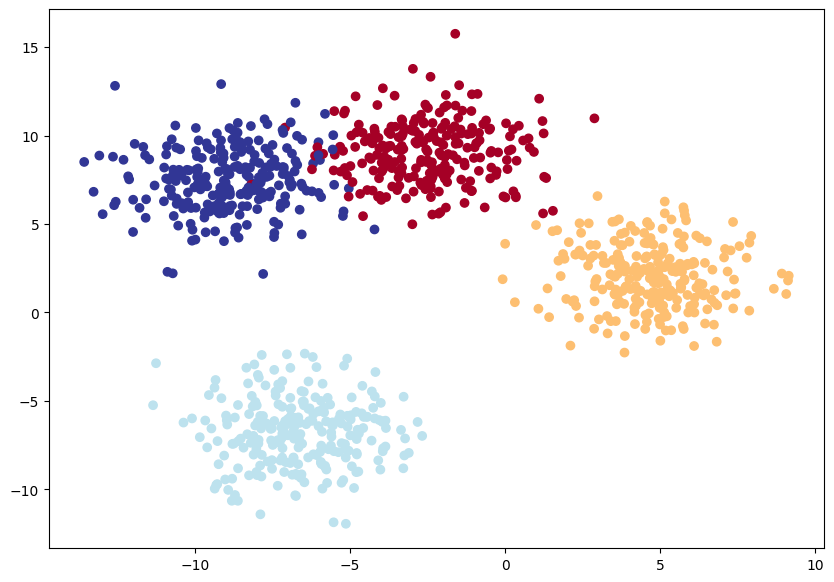

In [65]:
# Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [66]:
X_blob_train = X_blob_train.to(device)
y_blob_train = y_blob_train.to(device)
X_blob_test = X_blob_test.to(device)
y_blob_test = y_blob_test.to(device)

### 8.2 Building a multi-class classification model in PyTorch

In [67]:
# Build a multi-class classification model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer_stack(x)

In [68]:
model_4 = BlobModel(
    input_features=2,
    output_features=4,
    hidden_units=8).to(device)

In [69]:
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Create a loss function and an optimizer for a multi-class classification model

In [70]:
# Create a loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer for multi-class classification
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)

### 8.4 Getting prediction probabilities for a multi-class PyTorch model

In order to evaluate and train and test our model, we need to convert our model's outputs (logits) to prediction probabilities and then to predictions lagels.

Logits (raw output of the model) -> Pred probs (use `torch.softmax`) -> Pred labels (take the argmax of the prediction probabilities)

In [71]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)
    y_pred_prob = torch.softmax(y_logits, dim=1)
    y_pred = torch.argmax(y_pred_prob, dim=1)
y_pred[:10]

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

### 8.5 Creating a training loop and testing loop for a multi-class PyTorch model

In [72]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 100

# Loop through data
for epoch in range(epochs):
    # Training
    model_4.train()

    y_logits = model_4(X_blob_train)
    y_pred_prob = torch.softmax(y_logits, dim=1)
    y_pred = torch.argmax(y_pred_prob, dim=1).unsqueeze(dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_pred_prob = torch.softmax(test_logits, dim=1)
        test_pred = torch.argmax(test_pred_prob, dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)

    # Print what's happenin'
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test loss: {test_loss:.4f} | Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.1629, Acc: 49.50% | Test loss: 1.0806 | Test acc: 86.50%
Epoch: 10 | Loss: 0.6614, Acc: 95.00% | Test loss: 0.6762 | Test acc: 86.50%
Epoch: 20 | Loss: 0.4498, Acc: 97.00% | Test loss: 0.4554 | Test acc: 86.50%
Epoch: 30 | Loss: 0.2851, Acc: 99.00% | Test loss: 0.2774 | Test acc: 86.50%
Epoch: 40 | Loss: 0.1446, Acc: 99.00% | Test loss: 0.1326 | Test acc: 86.50%
Epoch: 50 | Loss: 0.0948, Acc: 99.00% | Test loss: 0.0845 | Test acc: 86.50%
Epoch: 60 | Loss: 0.0783, Acc: 99.00% | Test loss: 0.0676 | Test acc: 86.50%
Epoch: 70 | Loss: 0.0704, Acc: 99.00% | Test loss: 0.0592 | Test acc: 86.50%
Epoch: 80 | Loss: 0.0660, Acc: 99.00% | Test loss: 0.0543 | Test acc: 86.50%
Epoch: 90 | Loss: 0.0631, Acc: 99.00% | Test loss: 0.0511 | Test acc: 86.50%


### 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [73]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)
    y_pred_prob = torch.softmax(y_logits, dim=1)
    y_pred = torch.argmax(y_pred_prob, dim=1)

print(y_pred_prob[:10])
print(y_pred[:10])

tensor([[1.7122e-03, 9.9829e-01, 6.8397e-07, 4.2408e-07],
        [8.9545e-03, 9.6439e-05, 1.0155e-03, 9.8993e-01],
        [1.3925e-03, 8.9659e-04, 9.9456e-01, 3.1535e-03],
        [4.8905e-03, 9.9460e-01, 3.5850e-04, 1.4753e-04],
        [9.9356e-01, 6.4113e-03, 1.3523e-06, 2.5408e-05],
        [1.7750e-03, 1.0055e-05, 2.2503e-04, 9.9799e-01],
        [3.1388e-03, 2.5070e-03, 9.8664e-01, 7.7098e-03],
        [9.9769e-01, 5.1541e-04, 3.2671e-05, 1.7632e-03],
        [2.2937e-04, 1.2197e-04, 9.9902e-01, 6.2825e-04],
        [9.9838e-01, 1.2095e-03, 1.2022e-05, 3.9920e-04]], device='cuda:0')
tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')


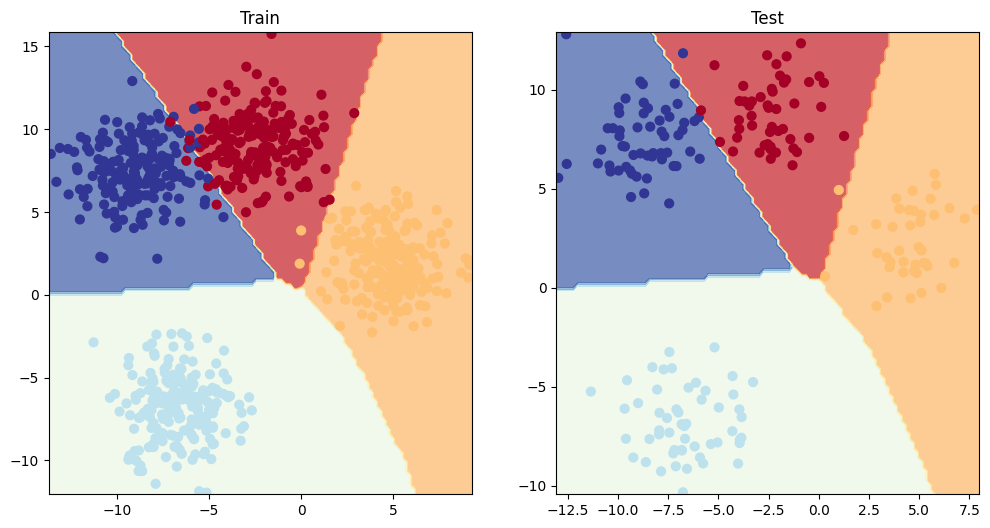

In [74]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. A few more classification metrics... (to evaluate our classification model)

* Accuracy - out of 100 samples, how many does our model get right?
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification report

See this article for when to use precision/recall: https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c

If you want access to a lot of PyTorch metrics, see TorchMetrics: https://torchmetrics.readthedocs.io/en/latest/

In [78]:
# Setup metric
torchmetric_accuracy = Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device)

# Calculate accuracy
torchmetric_accuracy(y_pred, y_blob_test)

tensor(0.9900, device='cuda:0')